<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Article data prep

_by Joe Hamman, March 8, 2021_

This notebook converts four netCDF files to Zarr stores for use in the CarbonPlan research article.


In [1]:
import fsspec
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from carbonplan_data.utils import set_zarr_encoding
from carbonplan_data.metadata import get_cf_global_attrs
from carbonplan.watermark import watermark

In [2]:
watermark(packages="fsspec,matplotlib,numpy,xarray,carbonplan,carbonplan_data")

Last updated: 2022-03-10T18:21:49.848368+00:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.10.2

fsspec         : 2022.2.0
matplotlib     : 3.4.3
numpy          : 1.20.3
xarray         : 2022.3.0
carbonplan     : 0.5.0
carbonplan_data: 0.4.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.4.129+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: 1bcd7bd023107b79ef21fc648545e5ed113da126



In [7]:
def process(in_uris, out_uri, plot=True, write=True):

    ds_out = xr.Dataset()

    for in_uri in in_uris:
        name = in_uri.split("_")[1]
        ds = xr.open_dataset(fsspec.open(in_uri).open(), engine="h5netcdf")
        da_coarse = ds["tea_q5"].coarsen(latitude=10, longitude=10).mean()
        ds_out[name] = da_coarse.reindex(latitude=np.sort(da_coarse.latitude.values))

        if plot:
            plt.figure()
            ds_out[name].plot(vmin=0, vmax=3000, cmap="viridis_r")

    if write:
        ds_out = ds_out.chunk(-1).pipe(set_zarr_encoding)
        ds_out.attrs = get_cf_global_attrs(version="1.0.0")
        ds_out.to_zarr(out_uri, mode="w")
    return ds_out

https://storage.googleapis.com/carbonplan-macroalgae/data/processed/article/costs.zarr
<xarray.Dataset>
Dimensions:            (latitude: 216, longitude: 432)
Coordinates:
  * latitude           (latitude) float64 -89.58 -88.75 -87.92 ... 88.75 89.58
  * longitude          (longitude) float64 -179.6 -178.8 -177.9 ... 178.8 179.6
Data variables:
    netcostpertonfeed  (latitude, longitude) float32 dask.array<chunksize=(216, 432), meta=np.ndarray>
    netcostpertonfood  (latitude, longitude) float32 dask.array<chunksize=(216, 432), meta=np.ndarray>
    netcostpertonfuel  (latitude, longitude) float32 dask.array<chunksize=(216, 432), meta=np.ndarray>
    netcostpertonsink  (latitude, longitude) float32 dask.array<chunksize=(216, 432), meta=np.ndarray>
Attributes:
    version:      1.0.0
    history:      Created: Thu Mar 10 18:26:13 2022
    institution:  CarbonPlan
    source:       /srv/conda/envs/notebook/lib/python3.8/site-packages/ipyker...
    hostname:     jupyter-jhamman
    usern

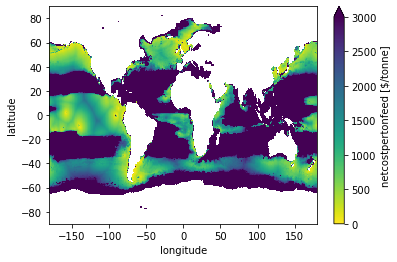

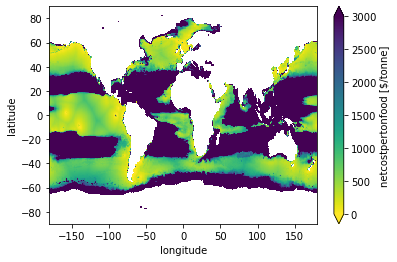

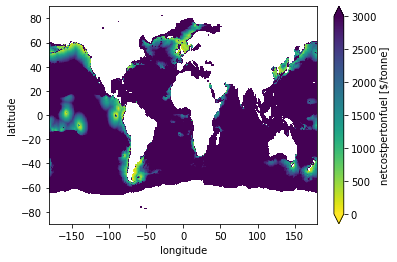

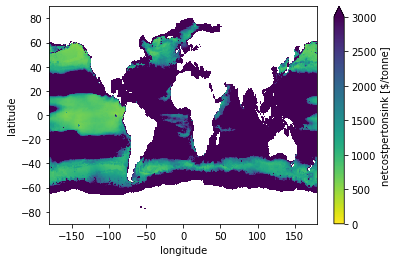

In [10]:
files = [
    "ambient_netcostpertonfeed_analysis_01_16_22.nc",
    "ambient_netcostpertonfood_analysis_01_16_22.nc",
    "ambient_netcostpertonfuel_analysis_01_16_22.nc",
    "ambient_netcostpertonsink_analysis_01_16_22.nc",
]
in_uris = [f"gs://carbonplan-macroalgae/data/raw/article/{f}" for f in files]
out_uri = f"gs://carbonplan-macroalgae/data/processed/article/costs.zarr"
public_uri = out_uri.replace("gs://", "https://storage.googleapis.com/")
ds = process(in_uris, out_uri, write=True)
print(public_uri)
print(ds)